# HAC clasifier Model
This is a CNN video classification model for classifying humans-animals (Objects), and cars. Build to assess video monitoring system to achieve smart video surveillance system by using normal conventional cameras. 

The purpose of the system is to provide an anti-theft and monitoring system that works precisely like a smart camera, by using a desktop application that is responsible for the motion detection process and extracting the object from detected motion (with the help of computer vision), then passes it to the classifier to recognize the extracted object. The video classification method used in this project is **Single-Frame-Classification** with the fix of the temporal feature problem by making the frames available from the motion detection process.

![Single-Frame-CNN-Architecture-1024x553.jpg](https://learnopencv.com/wp-content/uploads/2021/01/Single-Frame-CNN-Architecture-1024x553.jpg)

The dataset used to train this model is called [HAC-Dataset](https://drive.google.com/drive/folders/1fHAaIqSFiXmGMzuY6ENeW3qwrwNbmxHa?usp=sharing) and it's preassembled video data from **UCF50** human action recognition dataset, and **youtube** videos.


## Importing libraries

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Getting the data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Visualizing the data

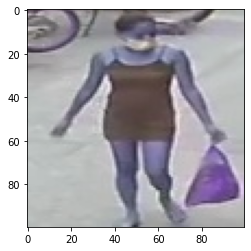

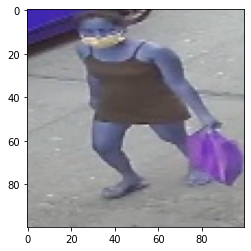

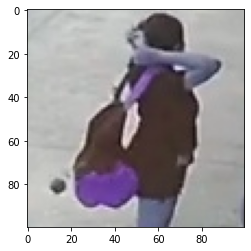

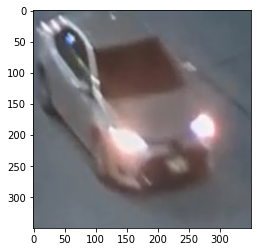

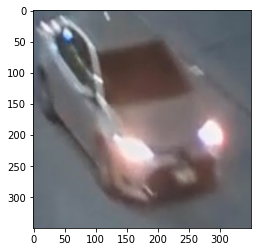

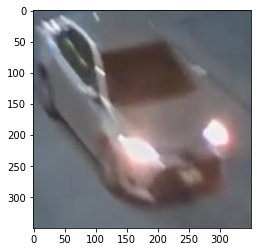

In [ ]:
# Access data directory
DATADIR = '/content/drive/MyDrive/HAC Dataset/train'
# two classes
CATEGORIES = ["Object", "Car"]
for category in CATEGORIES:
    path = os.path.join(DATADIR,category) 
    x=0
    for img in os.listdir(path):  
        x+=1
        img_array = cv2.imread(os.path.join(path,img))  # read the image
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display it!
        if x==3 : # get only 3 images per each class
            break        

## Prepare and preprocess the data

In [ ]:
# dimensions (input shape): 100x100
IMG_SIZE = 100
training_data = []

def create_training_data():
    for category in CATEGORIES:  # for object and person classes

        path = os.path.join(DATADIR,category)  # create path to object and person
        class_num = CATEGORIES.index(category)  # get the classification  (0 or 1). 0=object 1=person

        for img in tqdm(os.listdir(path)):  # iterate over each image per object and person
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to .. array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  
                pass
           

create_training_data() # call function
print(len(training_data)) 


100%|██████████| 2550/2550 [01:10<00:00, 36.13it/s] 

5939


## Randomize the data to avoid overfitting on training

In [ ]:
random.shuffle(training_data) # Done shuffling
for sample in training_data[:10]: # show first 10
    print(sample[1]) # show the lable

0
0
1
0
1
1
0
1
0
0


## Split the data from its labels to reshape it

In [ ]:
# split the array to show image and lables seperatly
X_train = []
y_train = []
for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE,3)
print(X_train.shape)

(5939, 100, 100, 3)


## Model shema

In [ ]:
# Buillding CNN:   
KerasModel = keras.models.Sequential([
      keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(IMG_SIZE, IMG_SIZE,3)),
      keras.layers.MaxPool2D(4,4),   
      keras.layers.Dropout(rate=0.5) ,
      keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),
      keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),
      keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),  
      keras.layers.MaxPool2D(4,4),  
      keras.layers.Dropout(rate=0.5) ,
      
      keras.layers.Flatten(),
      
      keras.layers.Dense(120,activation='relu') ,
      keras.layers.Dense(100,activation='relu') , 
      keras.layers.Dense(50,activation='relu') , 
      keras.layers.Dropout(rate=0.5) ,
      keras.layers.Dense(2,activation='softmax') 
    ])

Compiling Model

In [ ]:
# Run CNN:
KerasModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# show summary
print('Model Details are : ')
print(KerasModel.summary())

Model Details are : 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 200)       5600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 200)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 200)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 120)       216120    
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 80)        86480     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 50)        36050     
                                   

## Concise representation of the model

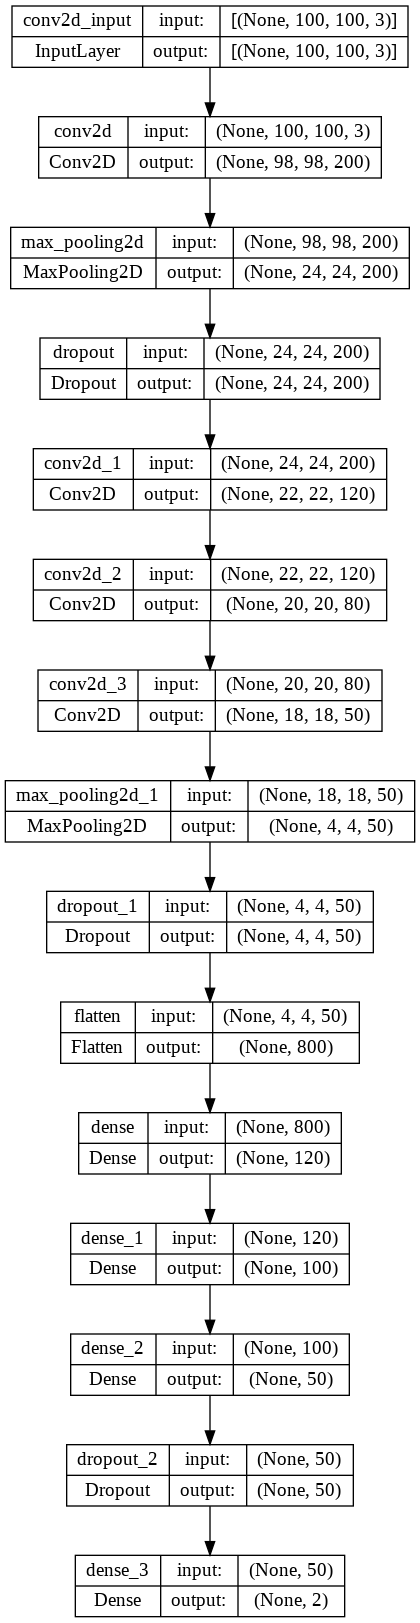

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(KerasModel, to_file = 'KerasModel_structure_plot.png', show_shapes = True, show_layer_names = True)

## Adding callbacks for advance model training

In [ ]:
# Set a learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

earlystop = EarlyStopping(monitor='val_loss', patience = 15, mode = 'min', restore_best_weights = True) # To prevent over fitting we will stop the learning after 10 .. epochs and val_loss value not decreased

# to stop or reduce if near overfiting
callbacks = [earlystop, learning_rate_reduction]

## Split the data into training data and validation data


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=43)#test_size 20% (4751: for training)

## Train the model

In [ ]:
batch_size = 32
epochs = 50

X_train= np.array(X_train)
y_train= np.array(y_train)
X_val= np.array(X_val)
y_val= np.array(y_val)

history = KerasModel.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, validation_split=0.25,
                         verbose=1, shuffle=True, callbacks= callbacks)

Epoch 1/50
112/112 [==============================] - 12s 37ms/step - loss: 1.2316 - accuracy: 0.5246 - val_loss: 0.6817 - val_accuracy: 0.5707 - lr: 0.0010
Epoch 2/50
112/112 [==============================] - 4s 33ms/step - loss: 0.6816 - accuracy: 0.5669 - val_loss: 0.6322 - val_accuracy: 0.6279 - lr: 0.0010
Epoch 3/50
112/112 [==============================] - 4s 32ms/step - loss: 0.6650 - accuracy: 0.5933 - val_loss: 0.5803 - val_accuracy: 0.7298 - lr: 0.0010
Epoch 4/50
112/112 [==============================] - 4s 33ms/step - loss: 0.5899 - accuracy: 0.6899 - val_loss: 0.4587 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 5/50
112/112 [==============================] - 4s 32ms/step - loss: 0.5149 - accuracy: 0.7474 - val_loss: 0.3752 - val_accuracy: 0.8215 - lr: 0.0010
Epoch 6/50
112/112 [==============================] - 4s 33ms/step - loss: 0.4581 - accuracy: 0.7825 - val_loss: 0.3809 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 7/50
112/112 [==============================] - 4s 35ms/s

## Evaluate the model performance

In [ ]:
model_evaluation_history = KerasModel.evaluate(X_val ,y_val, verbose=1)
print('Accuracy is: ', model_evaluation_history[0])
print('Loss is: ', model_evaluation_history[1])

38/38 [==============================] - 1s 13ms/step - loss: 0.0716 - accuracy: 0.9756
Accuracy is:  0.07156000286340714
Loss is:  0.9755892157554626


## Save the model as .h5

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
KerasModel.save(model_file_name)

## Graph the model performance

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

## Graph the model training loss and validation loss

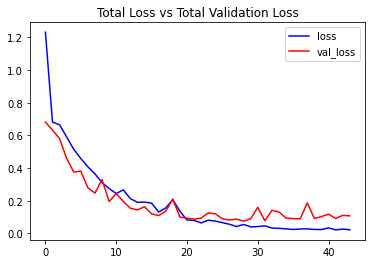

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

## Graph the model training accuracy and validation accuracy

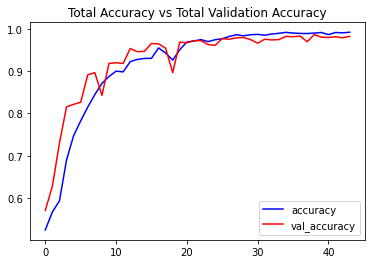

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## Prepare the test data

In [ ]:
IMG_SIZE = 100
test_data = []

DATADIR = '/content/drive/MyDrive/HAC Dataset/test'

def create_testing_data():
    for img in tqdm(os.listdir(DATADIR)):  # iterate over each image
        try:
            img_array = cv2.imread(os.path.join(DATADIR,img))  # convert to .. array
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize images
            test_data.append([new_array])  
        except Exception as e:  
            pass
           

create_testing_data() # call function
print(len(test_data)) 


100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

12


## Reshape the data

In [ ]:
print(np.array(test_data).shape)
z_test = np.array(test_data).reshape(-1, IMG_SIZE, IMG_SIZE,3)

(12, 1, 100, 100, 3)


## Make prediction of the data

In [ ]:
prediction = KerasModel.predict(z_test)
print(prediction[2])

1/1 [==============================] - 0s 267ms/step
[0.14147414 0.8585259 ]


## Plot the images with it's prediction result

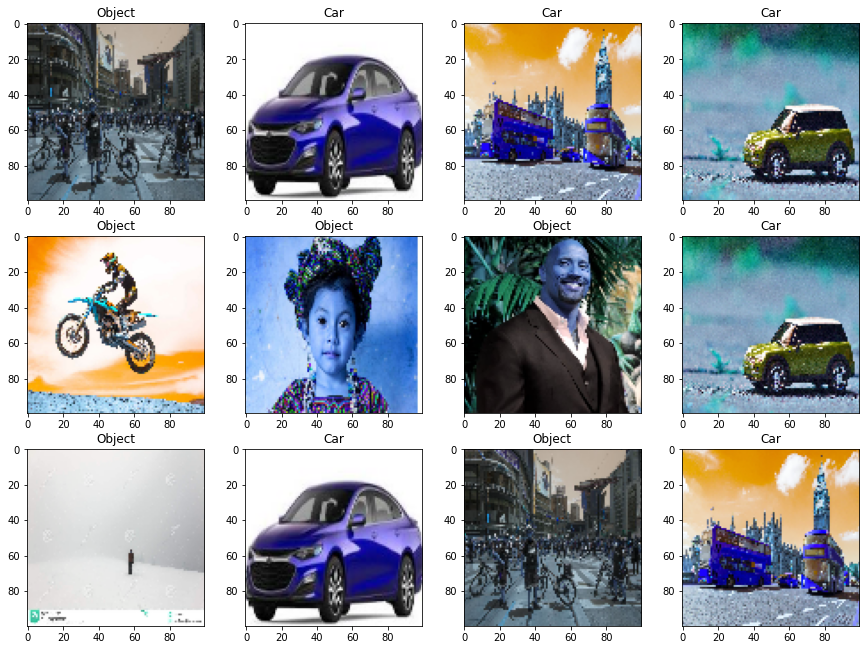

In [ ]:
z_test= z_test.squeeze()

plt.figure(figsize=(15, 15)) 
for n,i in enumerate(list(np.random.randint(0, len(z_test),12))):
    plt.subplot(4, 4, n+1)
    plt.imshow(z_test[i], cmap=plt.cm.gray)
    i = np.argmax(prediction[i])
    if i == 1:
        plt.title('Car')
    else:
        plt.title('Object')

# For Exported Model:

## Export the model

In [ ]:
path= '/content/(97%) LRCN_model___Date_Time_2022_11_07__19_33_31___Loss_0.07959956675767899___Accuracy_0.9739663004875183.h5'
model = keras.models.load_model(path)

In [ ]:
# !unrar x '/content/drive/MyDrive/HAC Dataset/train/Object/new.rar' -d '/content/drive/MyDrive/HAC Dataset/train/Object/'


## Prepare the test data

In [ ]:
IMG_SIZE = 100
test_data = []

DATADIR = '/content/New'

def create_testing_data():
    for img in tqdm(os.listdir(DATADIR)):  # iterate over each image
        try:
            img_array = cv2.imread(os.path.join(DATADIR,img))  # convert to .. array
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize images
            test_data.append([new_array])  
        except Exception as e:  
            pass
           

create_testing_data() # call function
print(len(test_data)) 


100%|██████████| 750/750 [00:00<00:00, 4959.24it/s]

750


## Randomize the data 

In [ ]:
random.shuffle(test_data) # Done shuffling
for sample in test_data[:2]: # show first 2
    print(sample[0]) # show the lable

[[[89 80 83]
  [88 79 82]
  [87 78 81]
  ...
  [82 78 84]
  [82 78 84]
  [82 78 84]]

 [[89 80 83]
  [88 79 82]
  [87 78 81]
  ...
  [83 79 85]
  [83 79 85]
  [83 79 85]]

 [[89 80 83]
  [88 79 82]
  [87 78 81]
  ...
  [83 79 85]
  [83 79 85]
  [83 79 85]]

 ...

 [[83 76 79]
  [84 77 80]
  [89 82 85]
  ...
  [95 86 89]
  [95 86 89]
  [95 86 89]]

 [[83 76 79]
  [83 76 79]
  [85 78 81]
  ...
  [95 86 89]
  [95 86 89]
  [95 86 89]]

 [[84 77 80]
  [84 77 80]
  [85 78 81]
  ...
  [95 86 89]
  [95 86 89]
  [95 86 89]]]
[[[72 71 75]
  [71 70 74]
  [71 70 74]
  ...
  [91 86 88]
  [91 86 88]
  [92 87 89]]

 [[72 71 75]
  [72 71 75]
  [72 71 75]
  ...
  [90 85 87]
  [90 85 87]
  [91 86 88]]

 [[72 71 75]
  [72 71 75]
  [72 71 75]
  ...
  [90 85 87]
  [90 85 87]
  [91 86 88]]

 ...

 [[64 56 57]
  [65 57 58]
  [65 57 58]
  ...
  [76 65 67]
  [75 64 66]
  [76 65 67]]

 [[64 56 57]
  [65 57 58]
  [65 57 58]
  ...
  [82 69 71]
  [81 68 70]
  [82 69 71]]

 [[49 41 42]
  [50 42 43]
  [51 43 44]
  .

## Reshape the data

In [ ]:
print(np.array(test_data).shape)
z_test = np.array(test_data).reshape(-1, IMG_SIZE, IMG_SIZE,3)

(750, 1, 100, 100, 3)


## Make prediction of the data

In [ ]:
prediction = model.predict(z_test)
print(prediction[2])
z_test= z_test.squeeze()

24/24 [==============================] - 2s 50ms/step
[0.5031144  0.49688554]


## Print the result of prediction

In [ ]:
car=0
obj=0
for i in range(0, len(z_test)):
    i = np.argmax(prediction[i])
    if i == 1:
        car+= 1
    else:
        obj+= 1

print('car: ', car, 'obj: ', obj)